In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd

import matplotlib.pyplot as plt
from copy import copy

In [3]:
from typing import Tuple, Dict, List, Any
import os

In [4]:
def read_json(file: str) -> dict:
    with open(file, 'r') as f:
        dict_ = json.load(f)
    return dict_

In [5]:
def read_jsons_in_dir(directory: str) -> Tuple[Dict, Dict, List]:

    return (
        read_json(os.path.join(directory, file+'.json'))
        for file in ['infra', 'simulation', 'results']
    )

In [6]:
infra, sim, res = read_jsons_in_dir('simulation1')

In [7]:
def routes(infra: Dict) -> List:
    return [route['id'] for route in infra['routes']]

In [8]:
def route_switches(infra: Dict) -> Dict[str, str]:
    
    return {
        route['id']:list(route['switches_directions'].keys())[0] 
        for route in infra['routes']
        if len(list(route['switches_directions'].keys()))!=0
    }

In [9]:
def route_limits(infra: Dict) -> Dict:
    points = {d['id']: (d['track'], d['position']) for d in infra['detectors']}
    points.update(
        {bs['id']: (bs['track'], bs['position']) for bs in infra['buffer_stops']}
    )
    return points

In [10]:
def track_section_lengths(infra: Dict) -> Dict:
    return {t['id']: t['length'] for t in infra['track_sections']}

In [11]:

import networkx as nx

def route_lengths(infra: Dict) -> Dict:

    ts = nx.Graph()

    for t in infra['track_section_links']:
        ts.add_edge(t['src']['track'], t['dst']['track'])
    lengths = {}
    points = route_limits(infra)
    for route in routes(infra):
        start = route.replace('rt.','').split('->')[0]
        end = route.replace('rt.','').split('->')[1]
        tracks = nx.shortest_path(ts, points[start][0],points[end][0])
        if len(tracks) == 1:
            lengths[route] = points[end][1] - points[start][1]
        else:
            lengths[route] =track_section_lengths(infra)[tracks[0]] - points[start][1]
            for t in tracks[1:-1]:
                lengths[route] +=track_section_lengths(infra)[t]
            lengths[route] += points[end][1]
    return lengths

In [12]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def draw_infra(infra: Dict):

    def mm(graph):
        graphbytes = graph.encode("ascii")
        base64_bytes = base64.b64encode(graphbytes)
        base64_string = base64_bytes.decode("ascii")
        display(Image(url="https://mermaid.ink/img/" + base64_string))

    g = "graph LR;"+";".join([route.replace('rt.','').replace("->","-->") for route in routes(infra)])
    mm(g)


# Schedule

In [13]:
from schedules import Schedule

In [14]:
def schedule_from_simulation(
        infra: Dict,
        res: List,
        simplify_route_names: bool = False
    ) -> Schedule:

    routes = [route['id'] for route in infra['routes']]

    s = Schedule(len(routes), len(res))

    routes_switches = {
        route['id']:list(route['switches_directions'].keys())[0] 
        for route in infra['routes']
        if len(list(route['switches_directions'].keys()))!=0
    }
    simulations = 'base_simulations'
    simulations = 'eco_simulations'

    for train in range(s.num_trains):
        route_occupancies = res[train][simulations][0]['route_occupancies']
        for route, times in route_occupancies.items():
            idx = routes.index(route)
            s._df.loc[idx, (train, 's')] = times['time_head_occupy']
            s._df.loc[idx, (train, 'e')] = times['time_tail_free']
    s._df.index = routes

    s._df.index = pd.Series(s.df.index.map(routes_switches)).fillna(pd.Series(s.df.index))

    s._df = s.df[~s.df.index.duplicated()] 

    if simplify_route_names:
        s._df.index = (
            s.df.index
            .str.replace('rt.','', regex=False)
            .str.replace('buffer_stop','STOP', regex=False)
        )

    return s


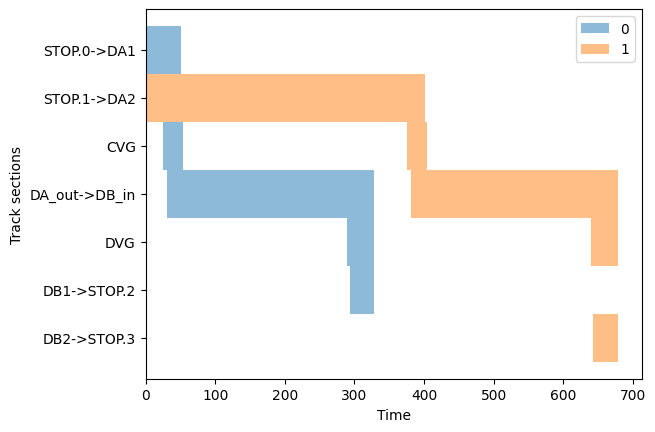

In [15]:
s = schedule_from_simulation(infra, res, simplify_route_names=True)
s.add_delay(1,'STOP.1->DA2', 350).sort().plot()

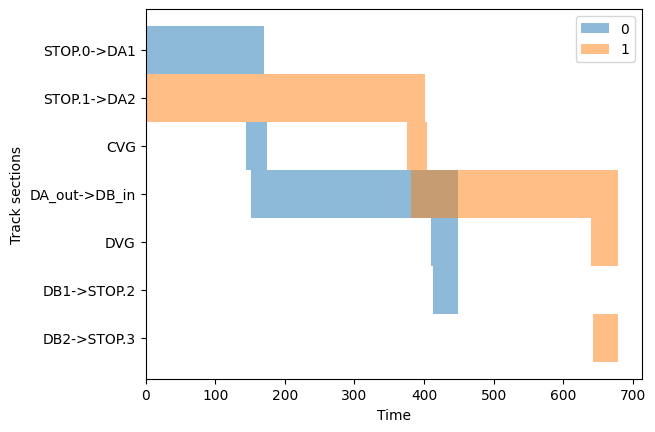

In [16]:
s.add_delay(1,'STOP.1->DA2', 350).add_delay(0,'STOP.0->DA1', 120).sort().plot()

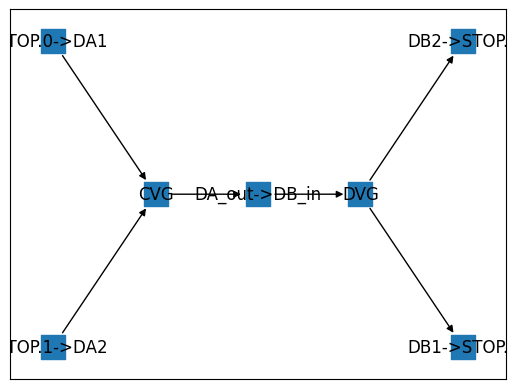

In [17]:
s.draw_graph()

# Regulation environment

In [18]:
from regul_env import RegulEnv

In [19]:
s = s.add_delay(1,'STOP.1->DA2', 350)

In [20]:
env = RegulEnv(s, stations = ['DB1->STOP.2', 'DB2->STOP.3'])

# Use case: 2 trains

In [21]:
from tqdm import tqdm
import numpy as np

total_delay_0 = []
total_delay_1 = []
delays= list(range(60,640,10))
for delay in tqdm(delays):
    env.reset(train=0, delay=delay, track_section='STOP.0->DA1')
    try:
        _, reward, _, _ = env.step(0)
    except:
        reward = np.nan
    total_delay_0.append(-reward)
    env.reset(train=0, delay=delay, track_section='STOP.0->DA1')
    try:
        _, reward, _, _ = env.step(1)
    except:
        reward = np.nan
    total_delay_1.append(-reward)

100%|██████████| 58/58 [02:16<00:00,  2.36s/it]


(0.0, 700.0)

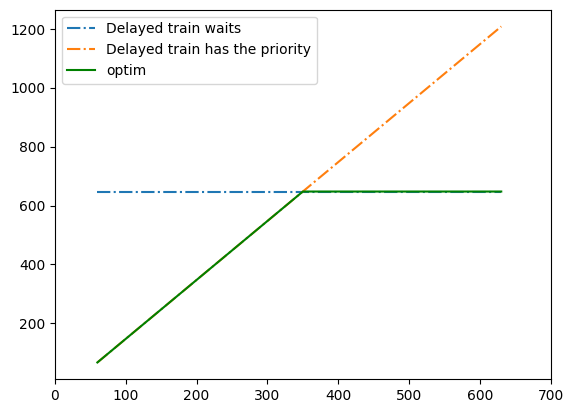

In [22]:
plt.plot(delays, total_delay_0, '-.', label='Delayed train waits')
plt.plot(delays, total_delay_1, '-.',  label='Delayed train has the priority')
plt.plot(delays, np.minimum(total_delay_0, total_delay_1), 'g-',label='optim')
plt.legend()
plt.xlim(0,700)


# Résultats du calcul de marche

In [23]:
base_head_positions = res[0]['base_simulations'][0]['head_positions']
eco_head_positions = res[0]['eco_simulations'][0]['head_positions']

t_base = [dict['time'] for dict in base_head_positions]
y_base = [dict['path_offset'] for dict in base_head_positions]
t_eco = [dict['time'] for dict in eco_head_positions]
y_eco = [dict['path_offset'] for dict in eco_head_positions]

In [33]:
len(t_base)

50

Text(0, 0.5, 'Position')

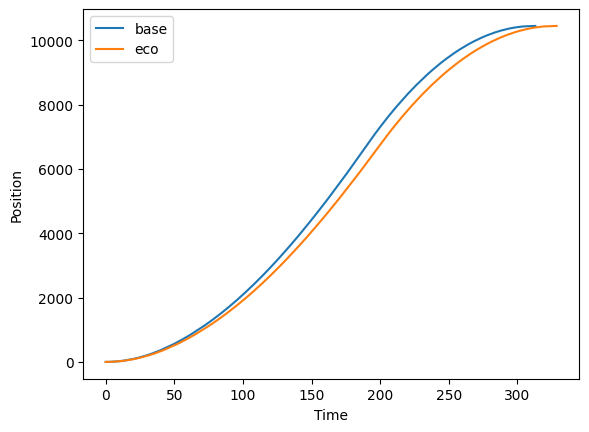

In [35]:
plt.plot(t_base, y_base, label='base')
plt.plot(t_eco, y_eco, label='eco')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')

In [25]:
base_speeds = res[0]['base_simulations'][0]['speeds']
eco_speeds = res[0]['eco_simulations'][0]['speeds']
t__base = [dict['time'] for dict in base_speeds]
y__base = [dict['speed'] for dict in base_speeds]
t__eco = [dict['time'] for dict in eco_speeds]
y__eco = [dict['speed'] for dict in eco_speeds]

Text(0, 0.5, 'speed')

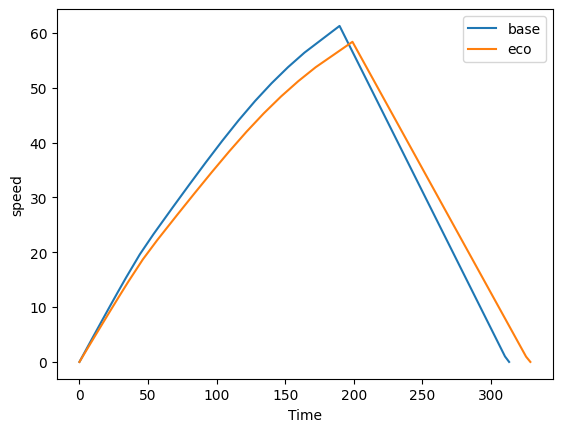

In [26]:
plt.plot(t__base, y__base, label='base')
plt.plot(t__eco, y__eco, label='eco')
plt.legend()
plt.xlabel('Time')
plt.ylabel('speed')

In [27]:
import datetime
str(datetime.timedelta(seconds=320))

'0:05:20'

https://stackoverflow.com/questions/48294332/plot-datetime-timedelta-using-matplotlib-and-python

In [28]:
G = env.schedule.graph

In [29]:
for r in routes(infra):
    print(r)

rt.DA1->DA_out
rt.buffer_stop.0->DA1
rt.DA2->DA_out
rt.buffer_stop.1->DA2
rt.DA_out->DB_in
rt.DB_in->DB2
rt.DB_in->DB1
rt.DB1->buffer_stop.2
rt.DB2->buffer_stop.3
